In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import torch
import torch.nn as nn

import model
import random

import os
from matplotlib import pyplot as plt
import Augment
import imageProcessing as ip
import csv

from Config import Config

In [25]:
def split_data(data, test_size=0.2, random_seed=None):
    """
    Splits a list of dictionaries into training and test datasets.
    
    Parameters:
        data (list of dict): The input data to be split.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_seed (int, optional): Random seed for reproducibility (default is None).
    
    Returns:
        tuple: (train_data, test_data) where both are lists of dictionaries.
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    # Shuffle the data
    shuffled_data = data[:]
    random.shuffle(shuffled_data)
    
    # Compute the split index
    split_idx = int(len(shuffled_data) * (1 - test_size))
    
    # Split the data
    train_data = shuffled_data[:split_idx]
    test_data = shuffled_data[split_idx:]
    
    return train_data, test_data

In [26]:
# Open the CSV file and read its contents into a dictionary
# The stored data is: picture_name, x1, y1, x2, y2 
with open(Config.coords_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

train_data, test_data = split_data(data)

In [29]:
"""
Plot keypoint detection model prediction side by side with expected keypoints
"""
def plot_model_prediction(kpd_model, data, n_images, augment_images = False, device=None):

    # Set model to evaluation mode (disables dropout, batchnorm, etc.)
    kpd_model.eval()

    # Sample n_images images to plot
    for image_data in random.sample(data, n_images):

        # Get image path. All images without bachground for the model are .png, so we need to change the suffix
        name = image_data["Image Name"]
        img_path = os.path.join(Config.images_folder_path + "/", name)
        base, _ = os.path.splitext(img_path)
        img_path = f"{base}.png"

        # Get keypoints
        x1, y1 = image_data["x1"], image_data["y1"]
        x2, y2 = image_data["x2"], image_data["y2"]

        # Prepare image and keypoints for the model
        img, kp = Augment.prepare_for_model(img_path, [(x1, y1), (x2, y2)], augment_images=augment_images)
        x, kp = model.to_xy(img, kp)
        # We somehow have to unsqueeze twice, could be worth investigating
        x_tensor = x.unsqueeze(0).unsqueeze(0).to(device)  # Move to the correct device (MPS or CPU)
        
        # Forward pass on the model
        with torch.no_grad():  # No gradients needed for inference
            pred = kpd_model(x_tensor)

        # Post-processing of the model output (e.g., rescale the coords which are outputed between 0 and 1)
        """
        This is completely messed up but somehow we have to switch x and y (it should be x1, y1, x2, y2 = ...)
        Somewhere in the code x and y were already switched, we need to find where...
        """
        y1pred, x1pred, y2pred, x2pred = pred[0][0].item() * Config.input_image_shape[0], pred[0][1].item() * Config.input_image_shape[1], pred[0][2].item() * Config.input_image_shape[0], pred[0][3].item() * Config.input_image_shape[1]

        img, keypoints = Augment.prepare_for_model(img_path, [(x1, y1), (x2, y2)])
        
        # If len(keypoints) != 2, then the augmentation lost a keypoint (too much rotation for example) and we are not interested
        if len(keypoints) == 2:

            # Add keypoints and prediction to the image and plot
            with_y = ip.add_point_channels(img, keypoints[0], keypoints[1])
            with_pred = ip.add_point_channels(img, (int(x1pred), int(y1pred)), (int(x2pred), int(y2pred)))

            # Plot side-by-side
            plt.figure(figsize=(10, 5))  # Set the figure size

            # First image
            plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
            plt.imshow(with_y)  # Display the first image
            plt.title("Expected")
            plt.axis('off')  # Turn off axes for better visual effect

            # Second image
            plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
            plt.imshow(with_pred)  # Display the second image
            plt.title("Prediction")
            plt.axis('off')

            # Display the plot
            plt.tight_layout()  # Adjust spacing
            plt.show()

In [30]:
image_names = [filename for filename in os.listdir(Config.images_folder_path) if filename.endswith(".jpg") or filename.endswith(".png")]

In [31]:
# Set the device to MPS (Metal Performance Shaders). If non-mac usage, try cuda
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: mps


Epoch 0: test loss = 0.0414862260222435


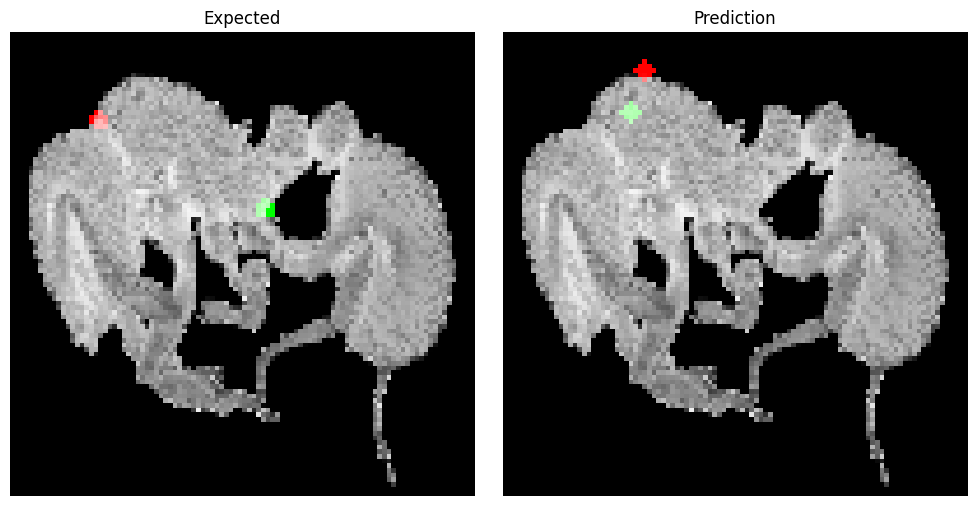

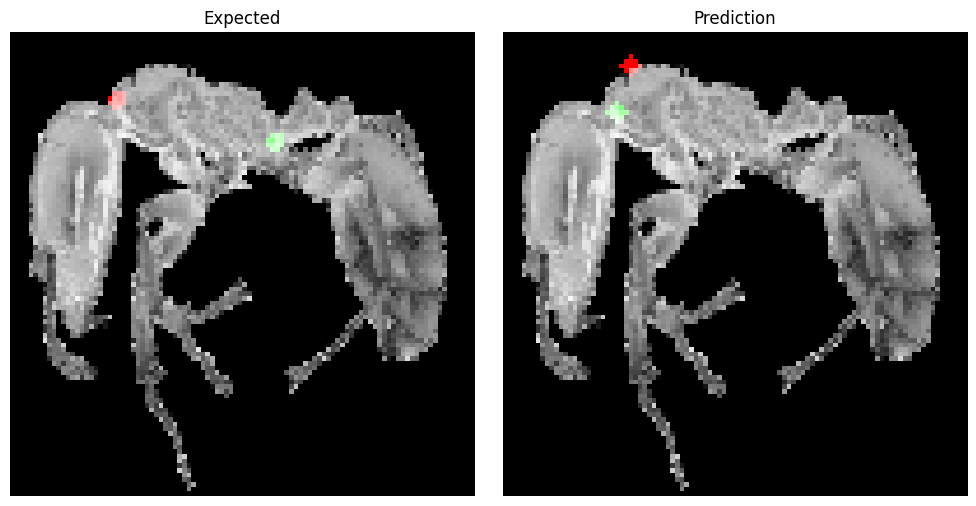

Epoch 25: test loss = 0.0037094491999596357


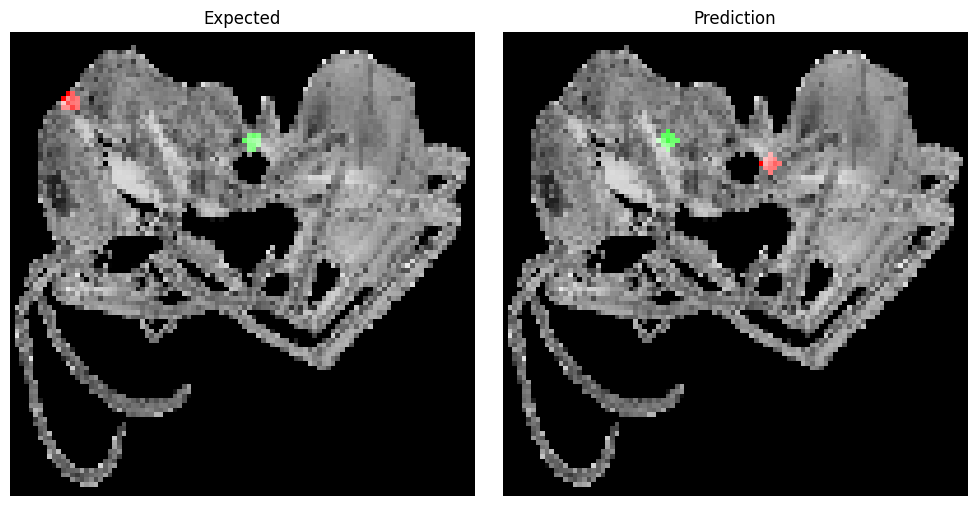

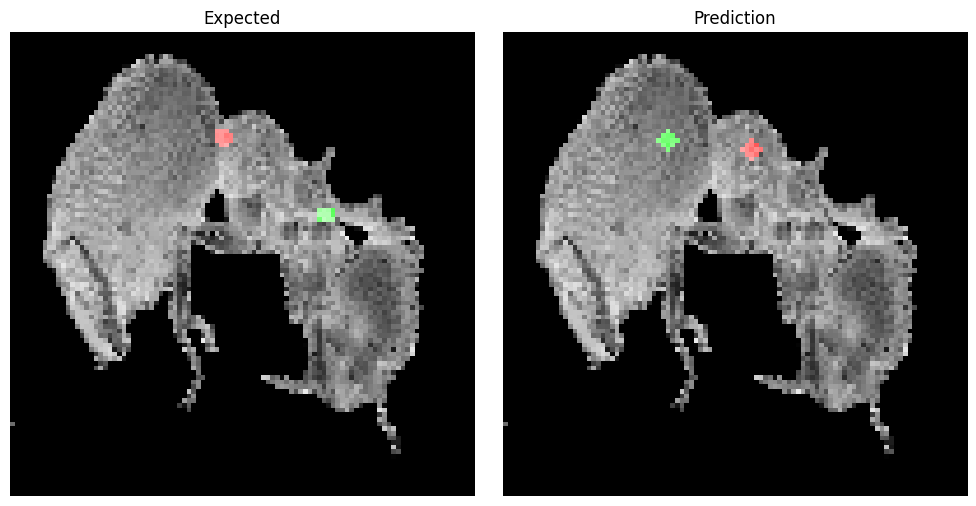

Epoch 50: test loss = 0.0035281372256577015


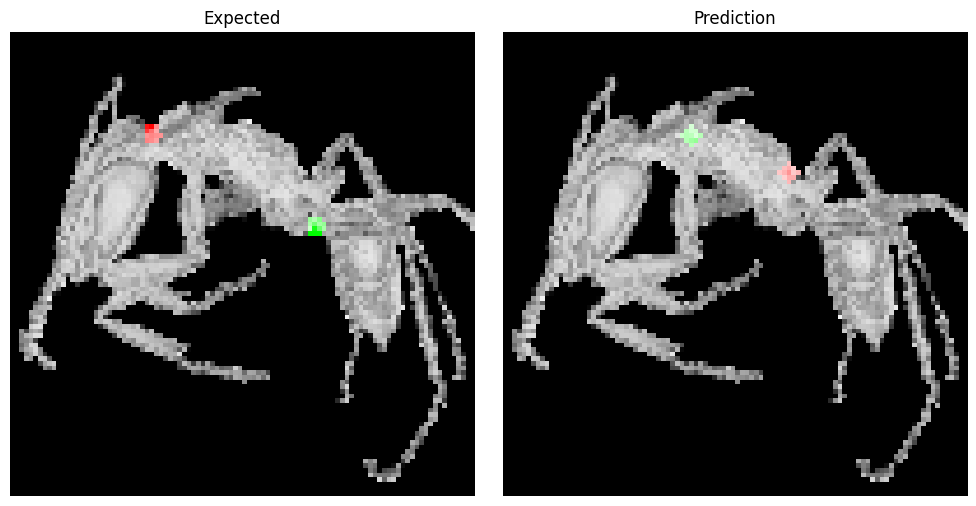

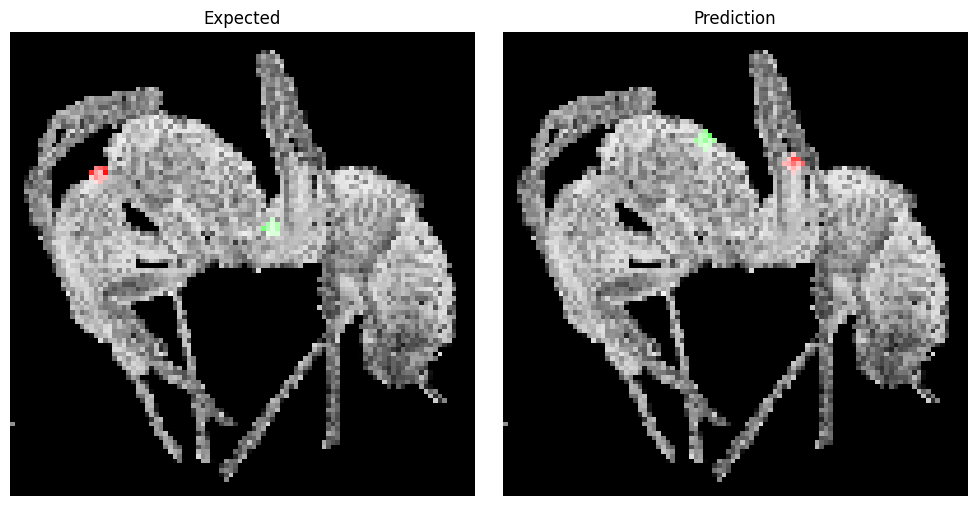

Epoch 75: test loss = 0.004139306023716927


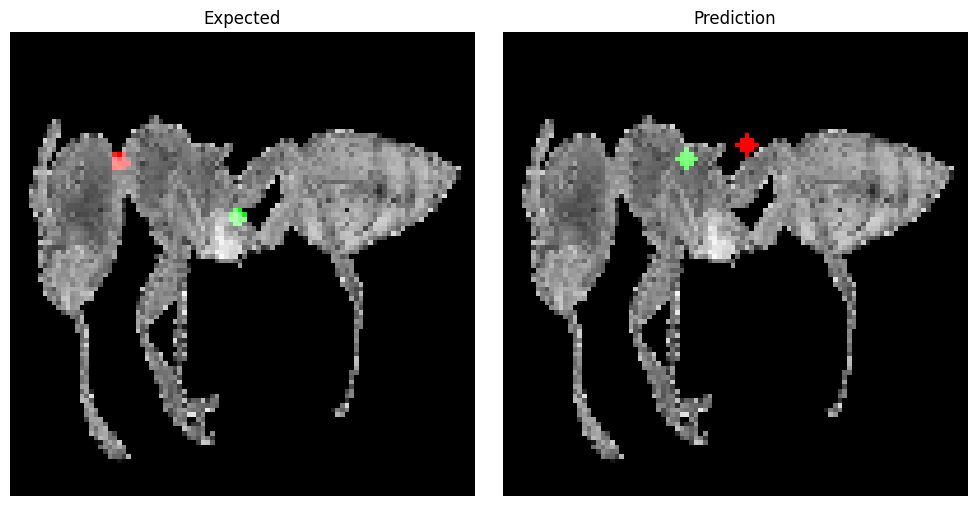

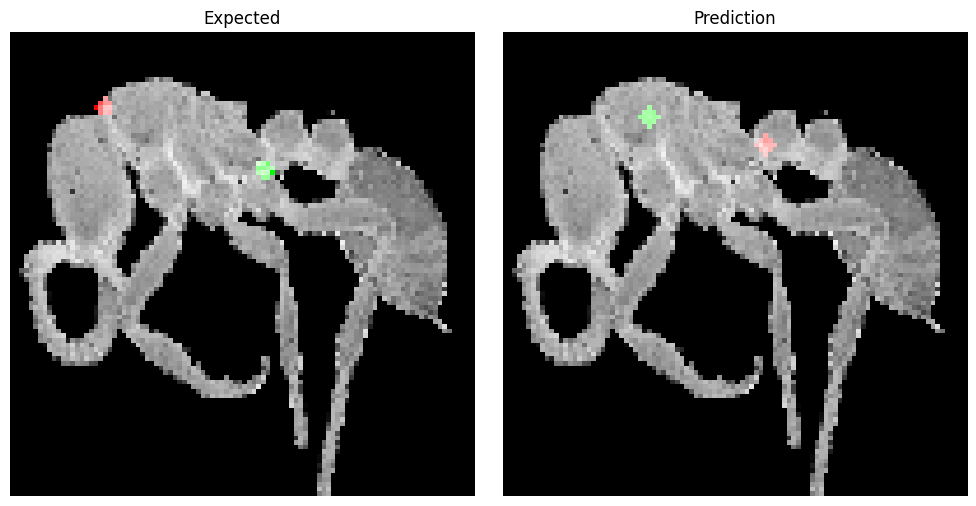

Possible overfitting, training aborted


In [44]:
last_test_loss = 1

kpd_model = model.KeypointDetectionModel().to(device)
batchsize = 50

criterion = nn.MSELoss()  # Loss for regression
optimizer = torch.optim.Adam(kpd_model.parameters(), lr=1e-4)


for epoch in range(250):
    images, keypoints, names = model.get_batch(train_data, batchsize=batchsize)  
    # Move the data to the MPS device
    images = images.to(device)
    keypoints = keypoints.to(device)
    optimizer.zero_grad()
    outputs = kpd_model(images)  # Forward pass
    loss = criterion(outputs, keypoints)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if not epoch%50:
        with torch.no_grad():
            kpd_model.eval()
            images, keypoints, names = model.get_batch(test_data, batchsize=batchsize)  
            # Move the data to the MPS device
            images = images.to(device)
            keypoints = keypoints.to(device)
            #optimizer.zero_grad()
            outputs = kpd_model(images)  # Forward pass
            test_loss = criterion(outputs, keypoints)  # Compute loss
            print(f"Epoch {epoch}: test loss = {test_loss}")

            plot_model_prediction(kpd_model, test_data, 2, device="mps")
            kpd_model.train()
    
        if test_loss >= last_test_loss:
            print("Possible overfitting, training aborted")
            break

        last_test_loss = test_loss


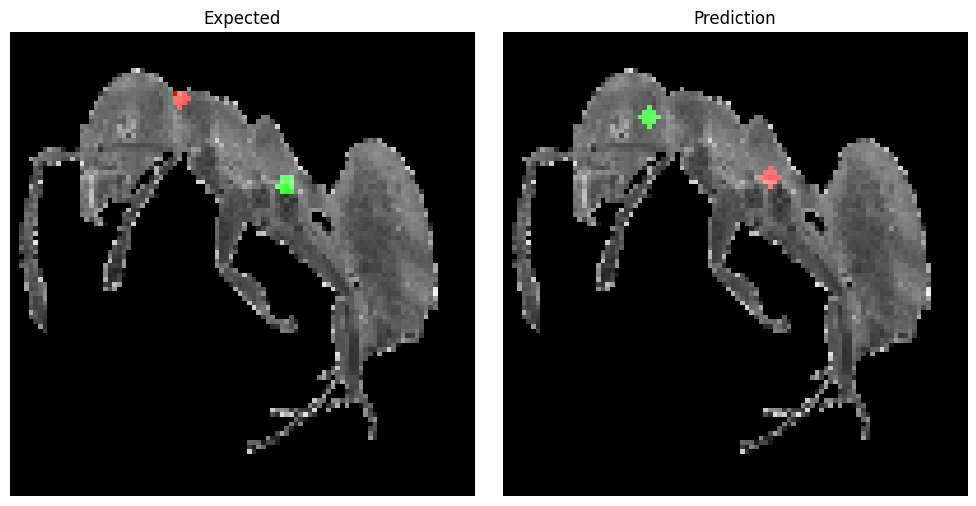

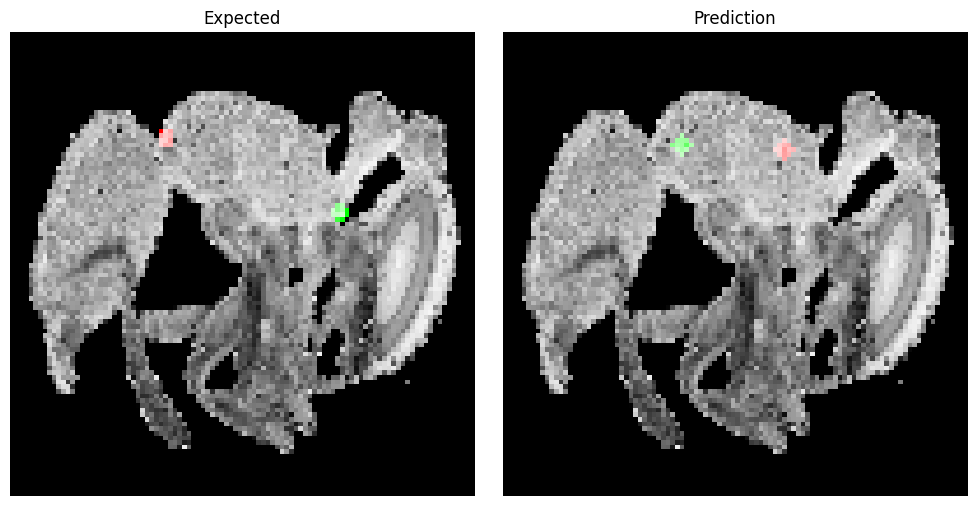

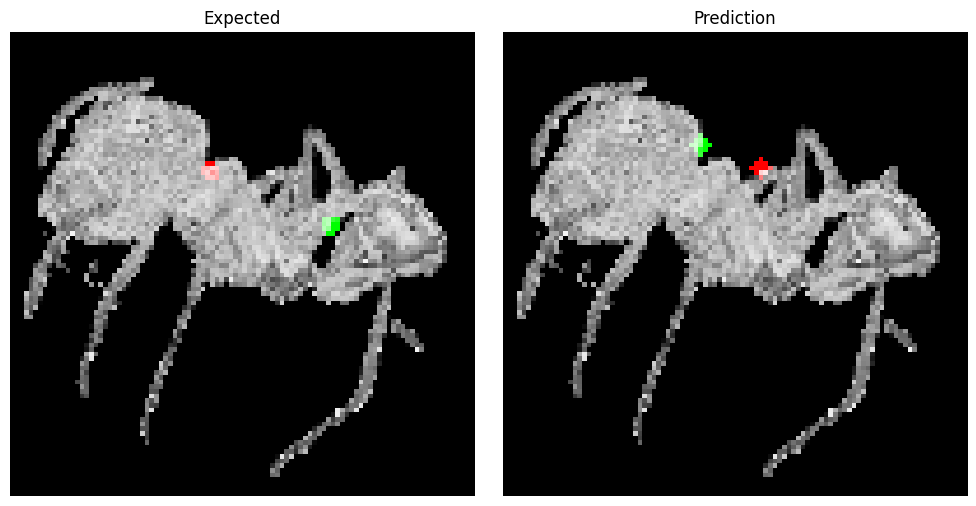

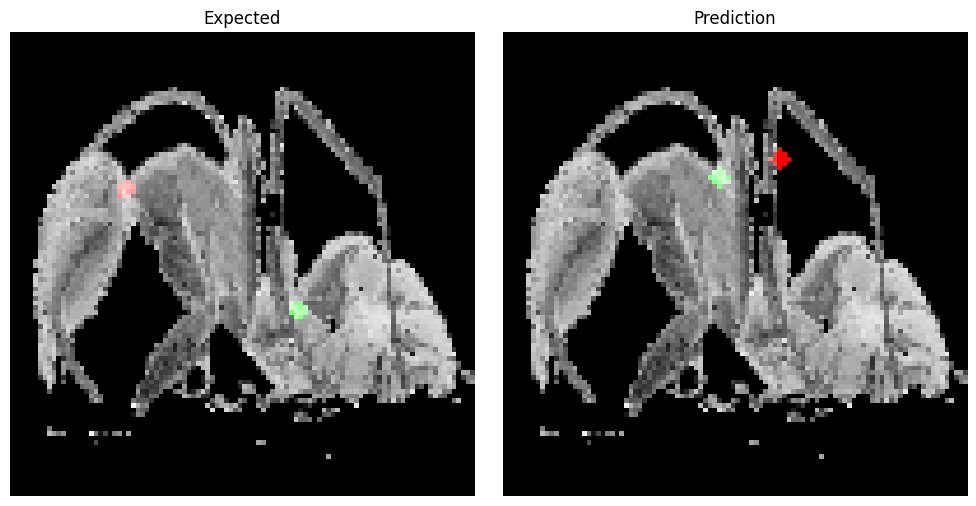

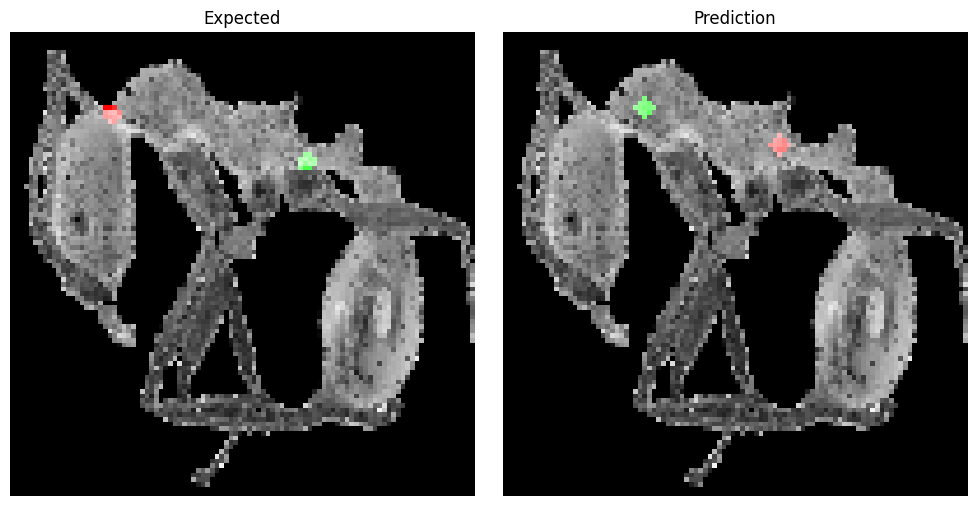

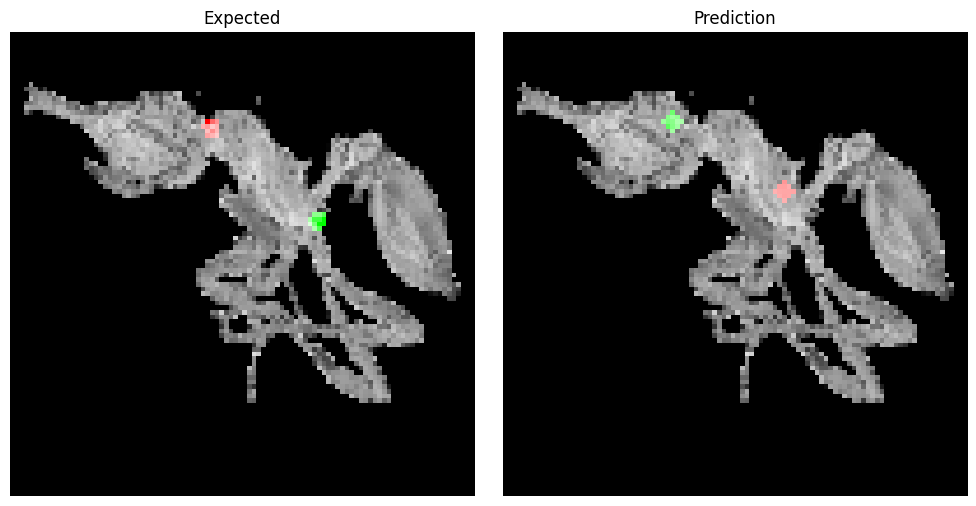

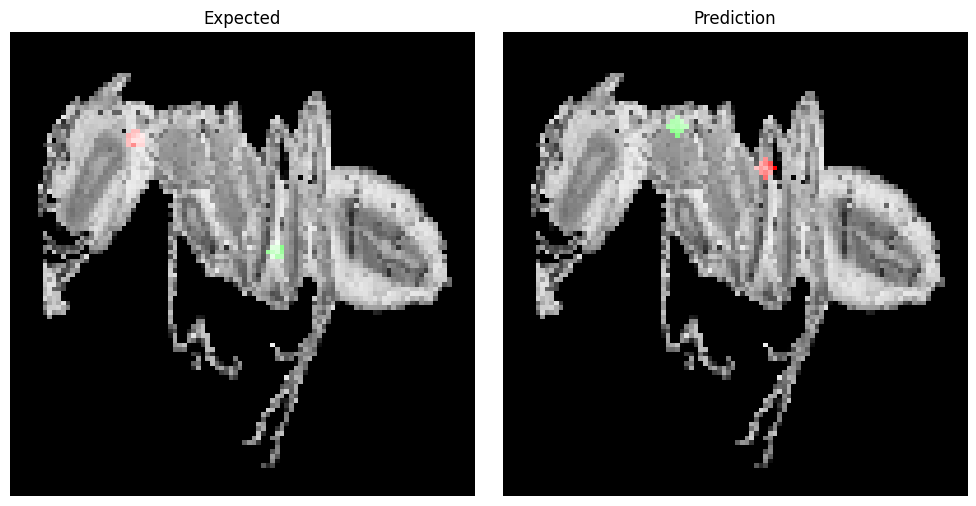

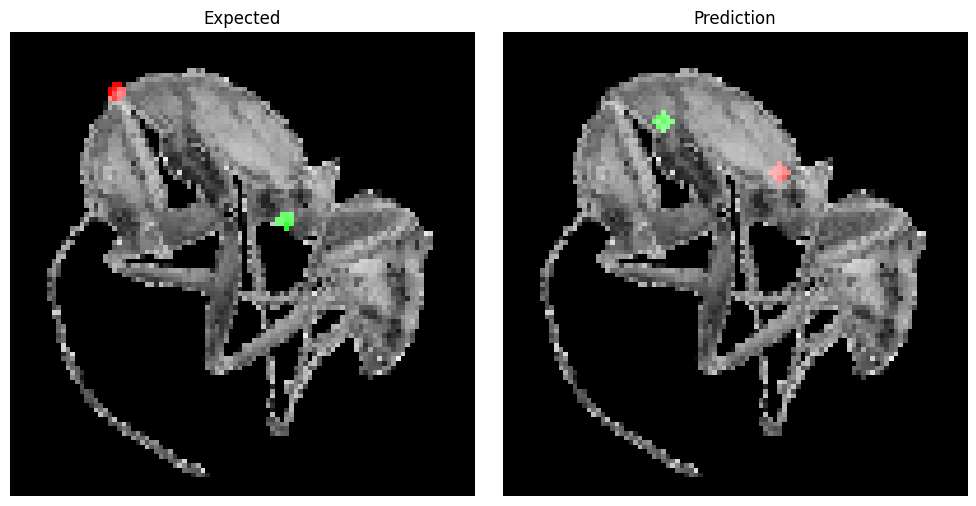

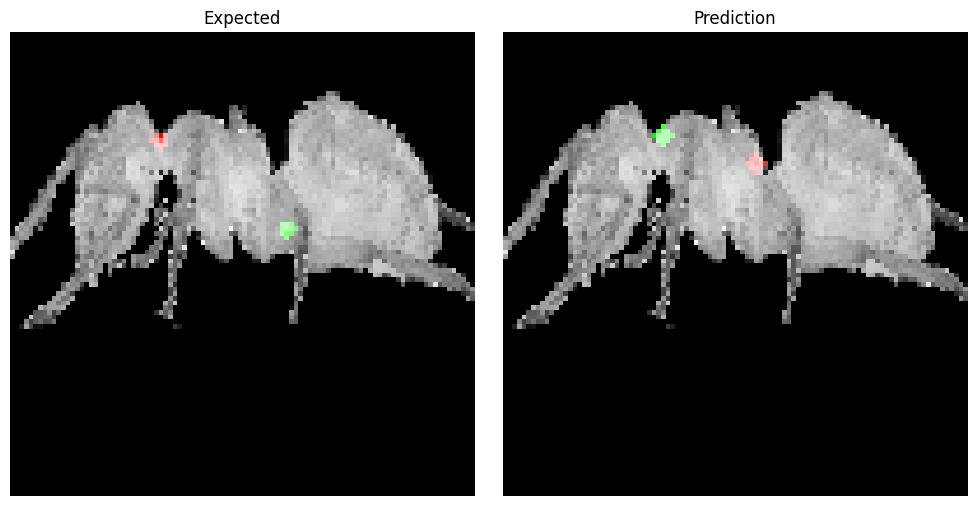

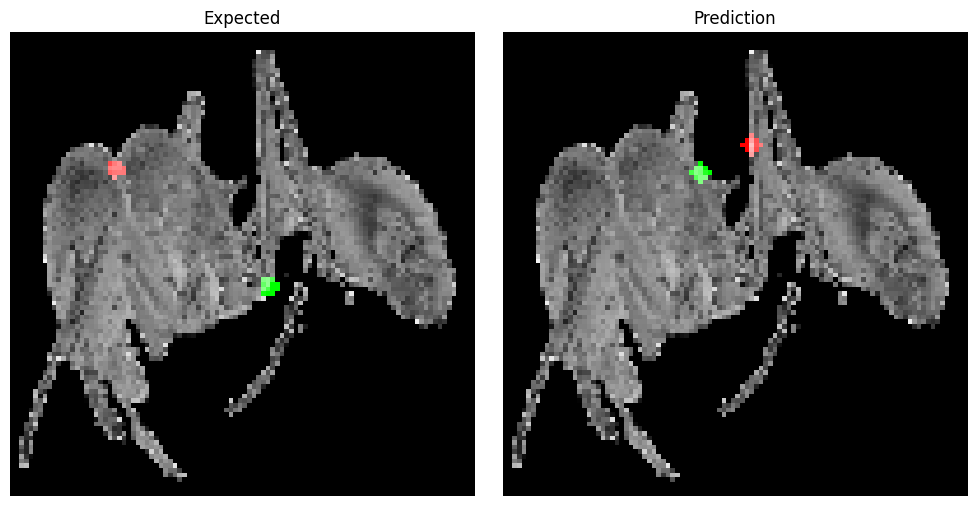

In [45]:
"""
Messed up thing number 2:
The two points got exchanged, need to investigate why
"""
plot_model_prediction(kpd_model, test_data, 10, augment_images=False, device=device)

- Use autoencoder ?
- Add head/train second model for confidence